<a href="https://colab.research.google.com/github/lakshitgosain/Tensorflow-ZTM/blob/main/TF_ZTM_06_Transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

Thu Jun  8 07:12:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
##Creating Helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-08 07:12:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-08 07:12:43 (72.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
#import series of helper functions for our notebook
from helper_functions import unzip_data,load_and_prep_image, plot_loss_curves, create_tensorboard_callback, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

the data we're downloading is from the original Food101 dataset but with less data samples(10%)

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")
train_dir="101_food_classes_10_percent/train"
test_dir="101_food_classes_10_percent/test"


--2023-06-08 07:12:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   142MB/s    in 13s     

2023-06-08 07:13:10 (116 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/oysters'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_

In [8]:
#Setup data inputs
import tensorflow as tf
IMAGE_SIZE=(224,224)
BATCH_SIZE=32

train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMAGE_SIZE,
                                                                              batch_size=BATCH_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=IMAGE_SIZE,
                                                              label_mode="categorical",
                                                              shuffle=False) #Dont shuffle the data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training the model with transfer learning with 10% of 101 Food Classes

Here are the steps we are going to take
* Setup a model checkpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers functional efficientNetB0 backboned-model (we'll create our own output layer))
* Compile the model
* Feature extract for 5 full passes(5 epochs on the dataset and validate on 15% of the data of the test data)

In [9]:
#Create checkpoint callback
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(save_best_only=True,
                                                       filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor='val_accuracy')

In [10]:
#Create data Augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation=Sequential([
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1/255.)# preprocessing built in into EfficientNetB0
],name='data_augmentation')

In [11]:
#Setup the base model and freeze it's layers (feature extraction)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Setup Model architecture with trainable top layers
inputs=layers.Input(shape=(224,224,3),
                    name="input_layer")
x=data_augmentation(inputs)#augment Images. This only happens during training
x=base_model(x,training=False) #put the base model in inference mode. Weights which needs to stay frozen will stay frozen

x= layers.GlobalAveragePooling2D(name="global_pool_layer")(x)

outputs=layers.Dense(len(train_data_all_10_percent.class_names),
                    activation='softmax',
                    name='output_layer')(x)

model=tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pool_layer (GlobalAv  (None, 1280)             0         
 eragePooling2D)                                                 
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [14]:
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                                   steps_per_epoch=len(train_data_all_10_percent),
                                                   epochs=5,
                                                    validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 119s 435ms/step - loss: 3.3868 - accuracy: 0.2689 - val_loss: 2.4211 - val_accuracy: 0.4886
Epoch 2/5
237/237 [==============================] - 75s 315ms/step - loss: 2.2005 - accuracy: 0.4990 - val_loss: 2.0225 - val_accuracy: 0.5196
Epoch 3/5
237/237 [==============================] - 67s 281ms/step - loss: 1.8097 - accuracy: 0.5679 - val_loss: 1.8883 - val_accuracy: 0.5267
Epoch 4/5
237/237 [==============================] - 65s 269ms/step - loss: 1.6106 - accuracy: 0.6098 - val_loss: 1.8068 - val_accuracy: 0.5365
Epoch 5/5
237/237 [==============================] - 59s 246ms/step - loss: 1.4412 - accuracy: 0.6491 - val_loss: 1.7737 - val_accuracy: 0.5405


In [15]:
fine_tuning_results=model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 66s 83ms/step - loss: 1.5837 - accuracy: 0.5837


[1.5837069749832153, 0.58368319272995]

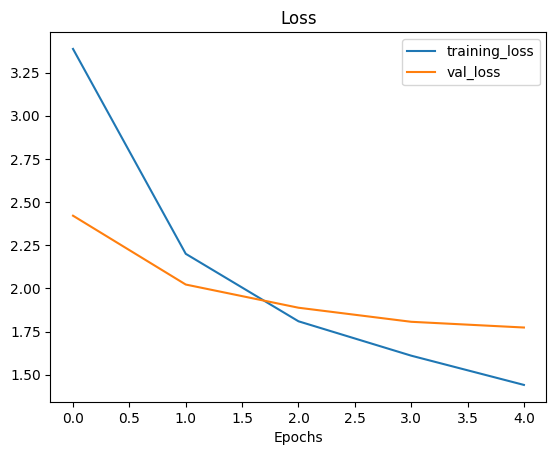

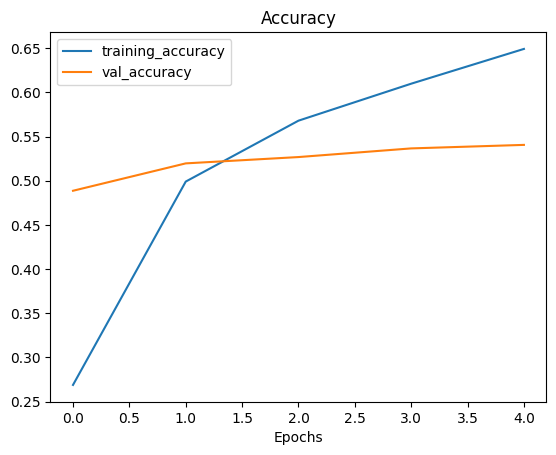

In [16]:
plot_loss_curves(history_all_classes_10_percent)

Looking at the curves, as the 2 curves should be very close to each other, which leads to situation where the model is overfitting

## Fine-tuning

In [17]:
#Unfreeze all of the layers in the base model 
base_model.trainable = True

#Refreeze the layers except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
#what layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_pool_layer True
output_layer True


In [20]:
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [21]:
#Fine Tune for 5 epochs
fine_tune_epochs=10 #model has already done 5 epochs feature extraction
initial_epochs=5

history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 68s 240ms/step - loss: 1.2146 - accuracy: 0.6836 - val_loss: 1.6961 - val_accuracy: 0.5511
Epoch 6/10
237/237 [==============================] - 53s 223ms/step - loss: 1.0802 - accuracy: 0.7092 - val_loss: 1.6815 - val_accuracy: 0.5559
Epoch 7/10
237/237 [==============================] - 50s 210ms/step - loss: 1.0126 - accuracy: 0.7240 - val_loss: 1.6977 - val_accuracy: 0.5530
Epoch 8/10
237/237 [==============================] - 48s 201ms/step - loss: 0.9368 - accuracy: 0.7493 - val_loss: 1.6825 - val_accuracy: 0.5556
Epoch 9/10
237/237 [==============================] - 46s 192ms/step - loss: 0.8898 - accuracy: 0.7622 - val_loss: 1.6792 - val_accuracy: 0.5564
Epoch 10/10
237/237 [==============================] - 47s 196ms/step - loss: 0.8275 - accuracy: 0.7772 - val_loss: 1.7164 - val_accuracy: 0.5498


In [22]:
all_classes_10_percent_fine_tune_results=model.evaluate(test_data)

790/790 [==============================] - 68s 86ms/step - loss: 1.4903 - accuracy: 0.6065


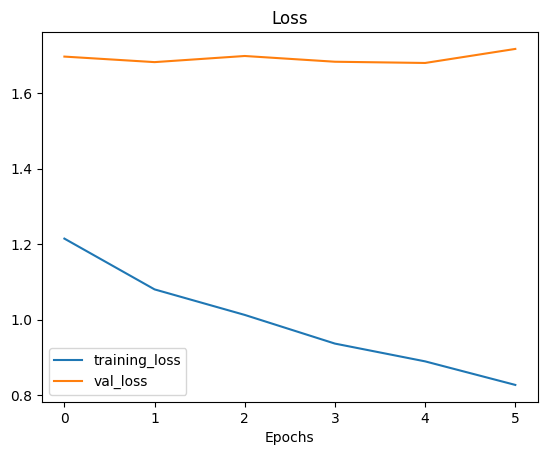

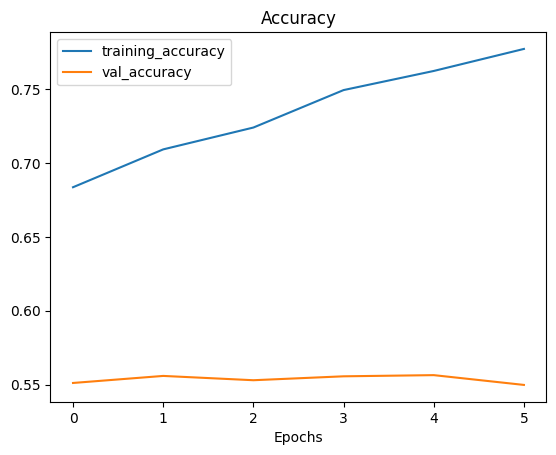

In [23]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

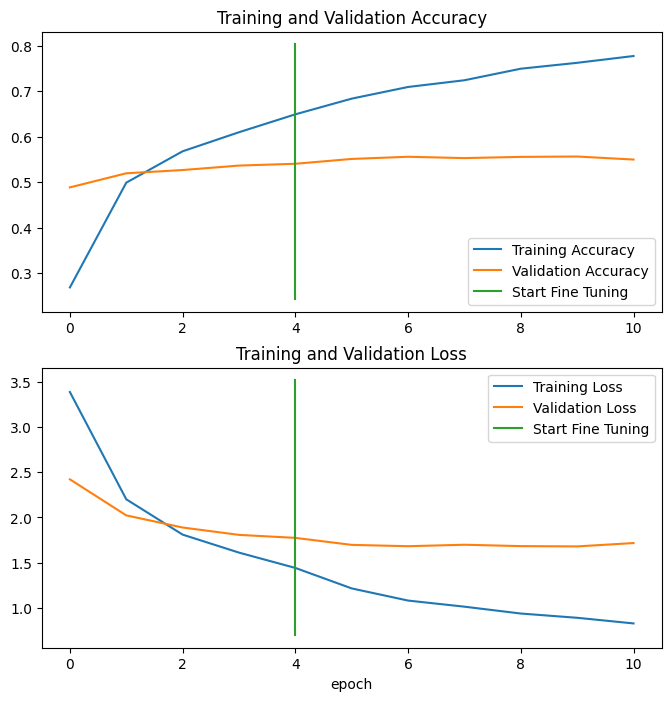

In [24]:
#compare the histories of feature extraction with fine-tuned model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)


## Saving and loading the model

To use the model in an extrnal app, we need to save and export it

In [25]:
#Save the model
#model.save("101_food_classes_model_fine_tuned_10_percent_data")

In [26]:
#Load and evaluate the saved model
# loaded_model =tf.keras.models.load_model("101_food_classes_model_fine_tuned_10_percent_data")

In [27]:
# loaded_model.evaluate(test_data)

Let's make some predictions and vizualize them and see which ones were the most wrong

In [28]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-06-08 07:30:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   143MB/s    in 0.3s    

2023-06-08 07:30:32 (143 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [29]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [30]:
model=tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [31]:
results_downloaded_model=model.evaluate(test_data)

790/790 [==============================] - 69s 85ms/step - loss: 1.8027 - accuracy: 0.6078


In [32]:
all_classes_10_percent_fine_tune_results

[1.4902822971343994, 0.6065346598625183]

In [33]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [34]:
preds_prob=model.predict(test_data, verbose=1) #set verbose to see how long is left

790/790 [==============================] - 73s 90ms/step


In [35]:
len(test_data)

790

In [36]:
len(preds_prob)

25250

In [37]:
preds_prob.shape

(25250, 101)

In [38]:
#Let's see what the first 10 predictions look like
preds_prob[10]

array([8.66758645e-01, 1.06682467e-08, 8.97231163e-04, 2.98574256e-11,
       1.19359580e-08, 2.52451636e-11, 1.78776531e-07, 1.49150314e-09,
       7.43701681e-02, 4.74565095e-05, 7.88795589e-08, 4.73205364e-10,
       9.88295884e-04, 4.71360728e-09, 9.51967086e-05, 3.80473146e-08,
       1.96486411e-07, 7.64913275e-04, 4.63440472e-07, 2.07787082e-07,
       3.97520722e-07, 6.02352031e-07, 2.73168621e-06, 7.80093444e-07,
       4.01718765e-08, 5.76192178e-08, 7.19973130e-08, 1.58951619e-11,
       2.75498496e-05, 6.87810189e-06, 1.76989190e-07, 2.09113641e-05,
       3.46416346e-05, 1.02143172e-11, 1.48571687e-07, 6.49165610e-10,
       1.37262277e-05, 3.96533096e-06, 2.23210191e-05, 2.05117967e-08,
       7.41940539e-06, 6.01402064e-07, 1.00604502e-05, 8.69767973e-08,
       1.21352750e-09, 4.20938818e-07, 1.28025931e-06, 3.94755872e-08,
       2.20744378e-11, 1.11111913e-04, 5.95505050e-08, 3.00479286e-09,
       2.45919097e-02, 1.49327952e-05, 4.66858739e-11, 2.53548904e-04,
      

In [39]:
preds_prob[0], len(preds_prob[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

In [40]:
import numpy as np
np.argmax(preds_prob[0])

52

In [41]:
train_data_all_10_percent.class_names[52]

'gyoza'

Our model outputs a prediction probabulity array (with N number of variables , where N is the number of classes ) for each sample passed to the prediction method

In [42]:
print(f"Number of prediction probabilities {len(preds_prob[0])}")
print(f"What prediction probability sample 0 looks like:{preds_prob[0]}" )
print(f"the hishgest value (predicted probab) by the model{preds_prob[0].argmax()}")

Number of prediction probabilities 101
What prediction probability sample 0 looks like:[5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 1.0569885e-06 2.12

In [43]:
#Get the pred classes of each label
pred_classes=preds_prob.argmax(axis=1)

#How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [44]:
#How many pred_classes do we have
len(pred_classes)

25250

Now we've got a predictions array of all our models predictions, to evaluate them, we need to compare them to the labels

In [45]:
#To get our test labels, we need to unravel our test_data BatchDataset

y_labels=[]
for images , labels in test_data.unbatch(): #from 790 batches to 25250 images
  y_labels.append(labels.numpy().argmax()) #We want the index value where 1 appears
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [46]:
#How many y_labels are there
len(y_labels)

25250

## Evaluating our model's predictions

one way to check that our model's prediction array is in the same order as our test labels araay is to find the accuracy score

In [47]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [48]:
#Let's try sklearn's accuracy score and see what it comes up with

In [49]:
from sklearn.metrics import accuracy_score
sklearn_accuracy=accuracy_score(y_labels, 
                                y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [50]:
#Does this metric comes close to our models evaluate results
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

In [51]:
#Let's create a Confusion Matrix
from helper_functions import make_confusion_matrix

In [52]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20)

In [53]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

We need to make some changes to make sure that the titles are printed vetically

In [56]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  #Changed( plot-x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [57]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20)

Classification Report

In [58]:
 from sklearn.metrics import classification_report

In [61]:
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

Model is performing good on some and poor on most classes. The above is class by class evaluation of our model;s predictions.

In [63]:
#Let's create a viz to have a better understanding of the above evaluation
classification_report_dict=classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [64]:
class_names=test_data.class_names

In [65]:
#Let's plot all of our classes f-1 scores
#Create emoty dict 
class_f1_scores={}
for k, v in classification_report_dict.items():
  if k=='accuracy':
    break
  else:
    #Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]]=v['f1-score']


In [66]:
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [69]:
#Turn f-1 scores into dataframe
import pandas as pd
f1_scores=pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                      "f1-scores":list(class_f1_scores.values())}).sort_values("f1-scores", ascending=False)

In [70]:
f1_scores

class_names  f1-scores
33              edamame   0.937143
63             macarons   0.895397
75                  pho   0.866538
91  spaghetti_carbonara   0.847656
69              oysters   0.834008
..                  ...        ...
56     huevos_rancheros   0.339833
22     chocolate_mousse   0.329159
77            pork_chop   0.308756
39            foie_gras   0.297491
0             apple_pie   0.240566

[101 rows x 2 columns]

<Axes: >

<Figure size 2000x2000 with 0 Axes>

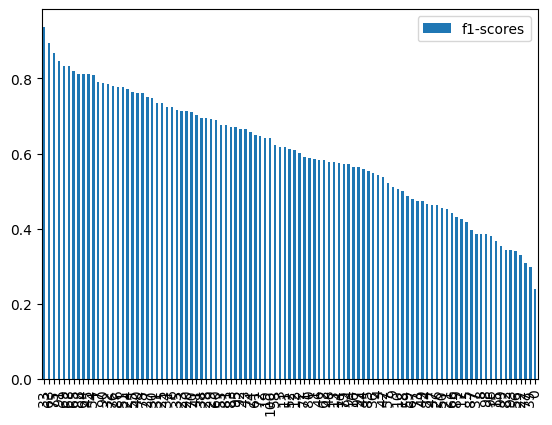

In [73]:
plt.figure(figsize=(20,20))
f1_scores.plot(kind='bar')


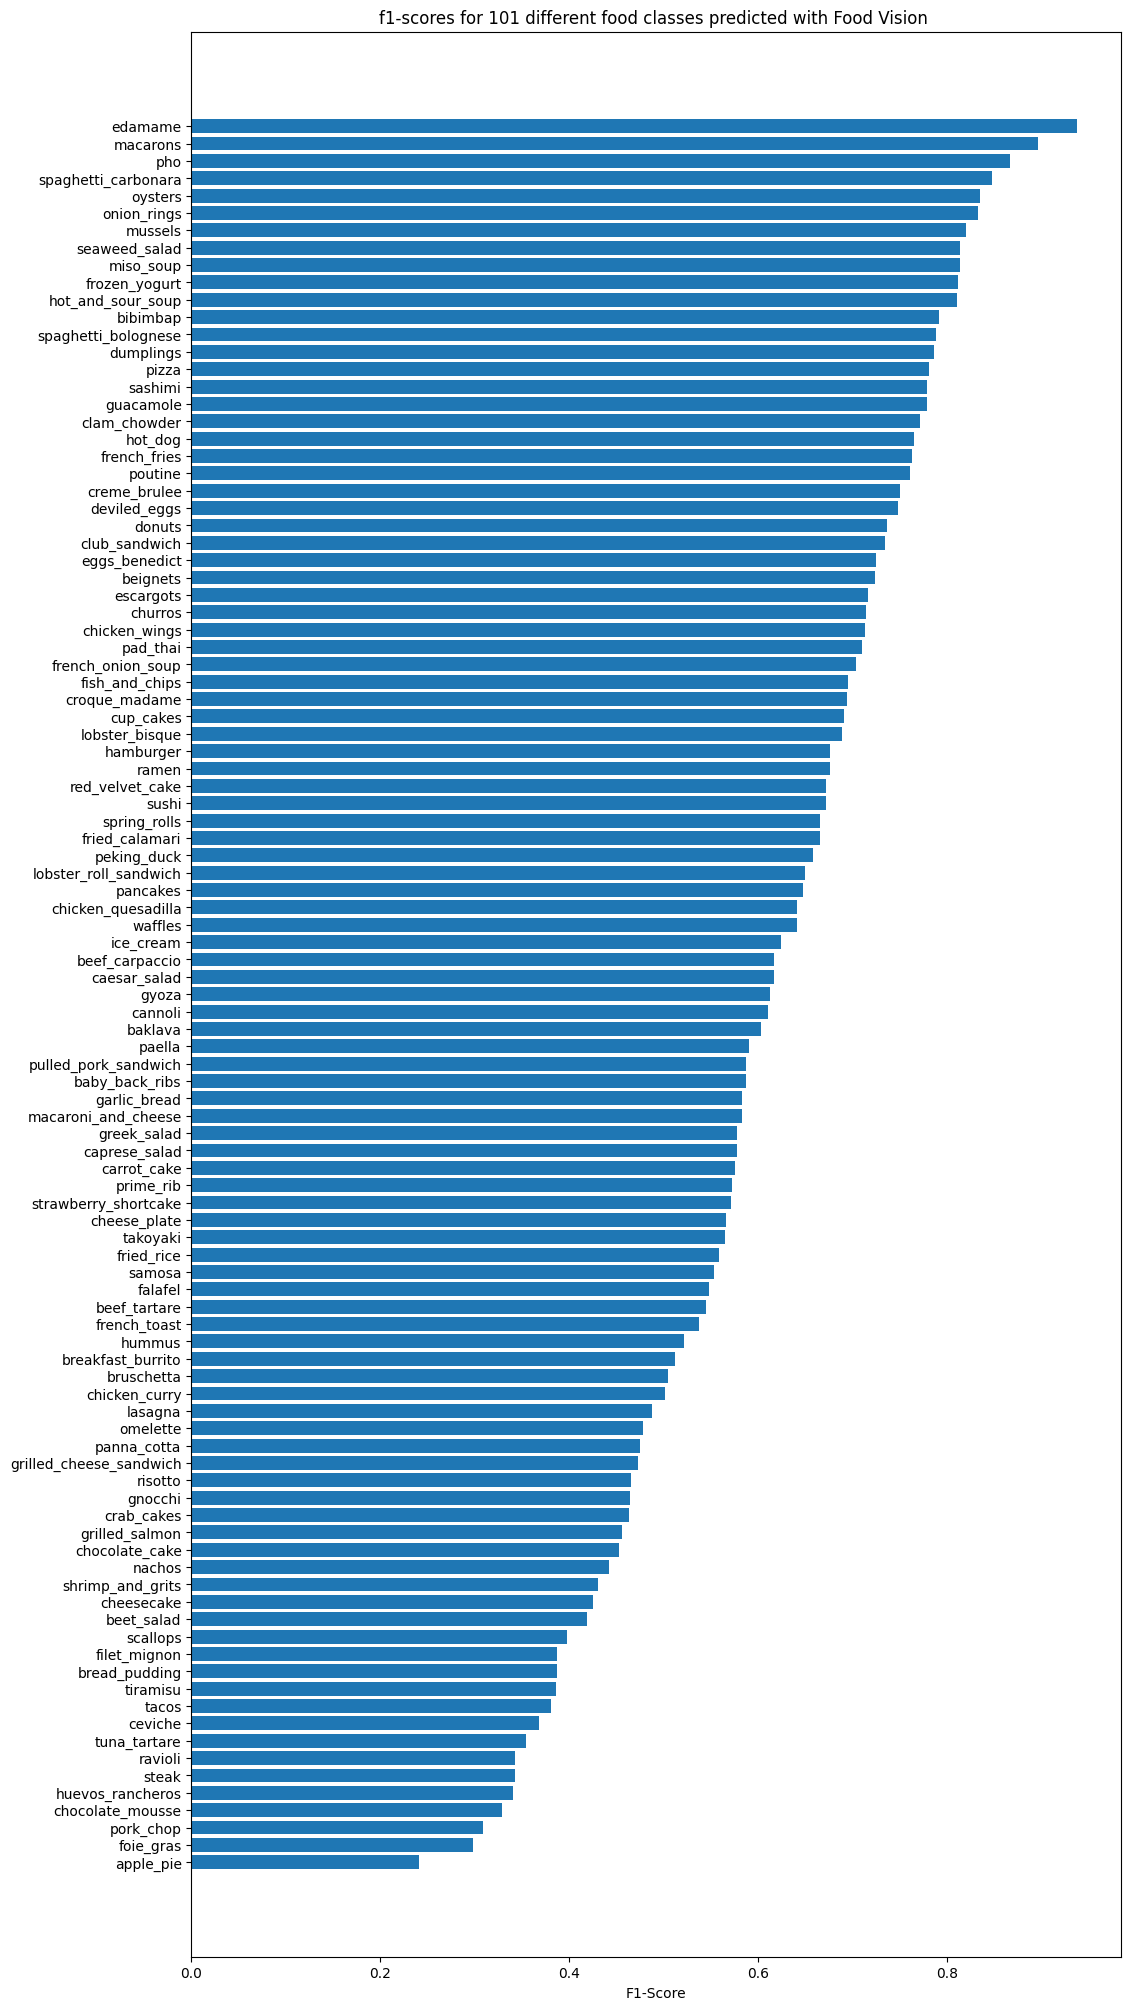

In [77]:
fig,ax= plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)), f1_scores["f1-scores"].values)
ax.set_yticks(range(len(f1_scores)))

ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel("F1-Score")
ax.set_title("f1-scores for 101 different food classes predicted with Food Vision ")
ax.invert_yaxis();

### Vis predictions on custom iages
How does our model goes in prediction of images what are not even in out test dataset

To visualize our model's prediction on our own images, we';; need a function to load and preprocess images, specifically it will need to :
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a tensor using tf.io.decode_image
* Resize the image tensor to be the same size as image our model has trained on using tf.image.resize()
* Scale the image to get all the pixel values between 0 and 1(if necessary)

In [82]:
#Create a function to load and pred images
def load_and_pred_image(filename, img_shape=224, scale=True):

  """
  Reads in an image from filename , iurns it into a tensor and reshapes into specifid shape(img_shape,img_shape,color_channels)
  
  Args:
  filename(str):path to target image
  image_shape(int): height/width dimensions of target image size
  scale(bool): scale pixel values from 0-255 to 0-1 

  Returns:
  Image Tensor
  
  """
  img=tf.io.read_file(filename)

  #Decode the image into a tensor
  img=tf.io.decoce_image(img, channels=3)

  #Resize the image
  img=tf.image.resize(img, [img_shape, img_shap])

  if scale:
    return img/255.
  else:
    return img 

  





now we've got a function to load and prepare target images, let's ow write some code to viz images, their target label and model's prediction

Specifically we'll write some code to
1. Load a few random iages from the test dataset
2. Make predictions on the loaded images
3. Plot the original images along with the model's predicition, pred probability and truth label

101_food_classes_10_percent/test/beef_tartare/1030025.jpg
1/1 [==============================] - 0s 30ms/step
[[3.25950928e-08 3.72696093e-07 6.75948471e-08 2.87266757e-05
  9.70475554e-01 4.05771416e-09 7.80339877e-14 1.06910147e-09
  9.45585537e-12 1.07861240e-07 3.93332921e-05 7.02582326e-10
  2.11456245e-06 2.43877640e-10 2.55516306e-06 6.94965547e-06
  5.87131799e-05 5.73832004e-08 2.61296562e-09 1.83416307e-06
  4.27905356e-09 1.80931057e-08 2.76617640e-09 3.62439722e-12
  1.04560525e-13 1.66173937e-08 4.95530665e-04 6.58575755e-12
  2.87826696e-09 2.33899256e-09 2.02219463e-10 9.47930675e-06
  5.55006596e-10 2.11591517e-16 1.26025490e-09 1.12196875e-11
  2.61870511e-02 8.73864053e-07 1.62253461e-10 2.99916428e-05
  6.15428715e-12 9.83355107e-15 5.88598822e-11 9.55208065e-11
  5.80638527e-07 5.25399238e-11 6.56836474e-10 3.58749190e-08
  2.01735885e-11 1.22950130e-08 3.13446913e-06 1.28051625e-09
  1.54181748e-07 1.50607984e-05 2.37496085e-13 5.08717761e-08
  2.78430321e-07 2.062

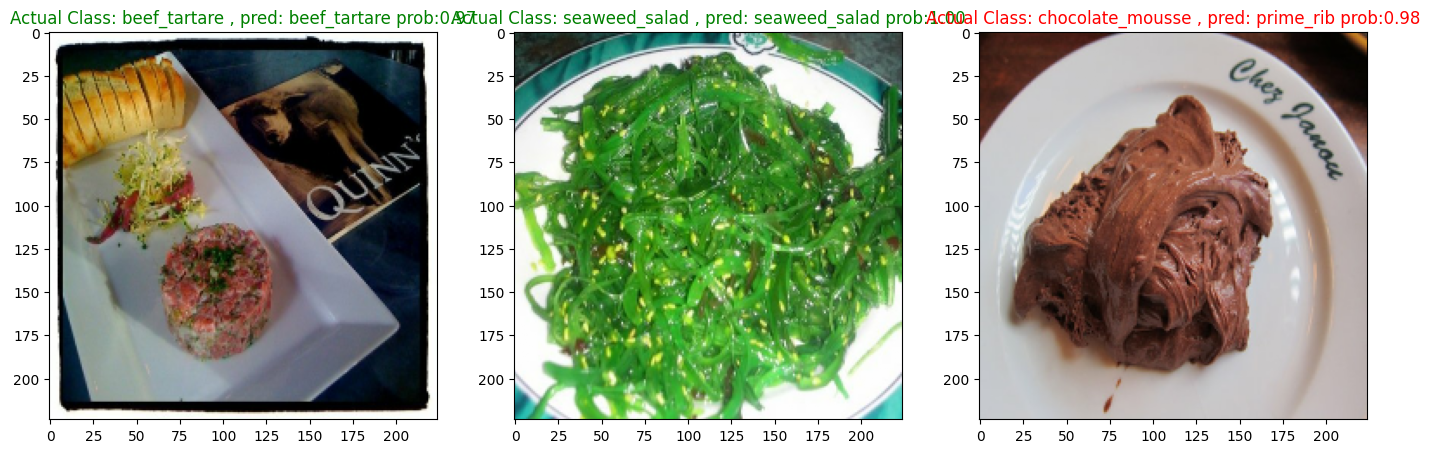

In [96]:
import os
import random

plt.figure(figsize=(17,10))

for i in range(3):
  #Choose a random image from a random class
  class_name=random.choice(class_names)
  file_name=random.choice(os.listdir(test_dir+'/'+class_name))
  filepath=test_dir + "/"+class_name + "/"+file_name
  print(filepath)

  img=load_and_prep_image(filepath, scale=False)
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()]
  print(pred_prob)
  print(pred_class)

  #Plot the images
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name==pred_class: #if predicted class atches with truth class, make text green
    title_color="g"
  else:
    title_color='r'
  plt.title(f"Actual Class: {class_name} , pred: {pred_class} prob:{pred_prob.max():.2f}", c=title_color)
  plt.axis=False;


Find where the model has a very high pred probab but makes the predictions wrong

Can reveal insights such as 
* Data issues(wrong labels)
* Confusing classes(Get better/more diverse data)

To fins out, we need to write out the code and do the following
1. Get all of the image file paths in the test dataset use list_files method
2. Ceate a pandas Dataframe of the image filepaths , ground truth labels, predicted classes(from our model), max prediction probabilities
3. use our Dataframe to find all the wrong predictions (where the ground trugh label doesn't match the prediction)
4. Sort the dataFrame based on wrong predictions (have the hightest prediction probability as the top)
5. Viz the images with the hightest predictions probabs but have the wrong predictions

In [99]:
#Get all of the image file paths in the test dataset
filepaths=[]
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]


[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [101]:
#2. Creatw a dataframe of different parameters for each of our images

import pandas as pd
pred_df=pd.DataFrame({"img_path":filepaths,
                      "y_true":y_labels,
                      "y_pred":pred_classes,
                      "pred_conf":preds_prob.max(axis=1),#Get the max pred prediction probability
                      "y_true_classname": [class_names[i] for i in y_labels],
                      "y_pred_classname":[class_names[i] for i in pred_classes]})

In [102]:
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658606        apple_pie  pulled_pork_sandwich  
4       0.367900        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690628          waffles               waffles  

[25250 rows x 6 columns]

In [103]:
pred_df['pred_correct']= pred_df['y_true']==pred_df['y_pred']

In [104]:
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.847419        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658606        apple_pie  pulled_pork_sandwich         False  
4       0.367900        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972823          waffles               waffles          True  
25246   0.878028          waffles          cheese_plate         False  
25247   0.537899          waffles               waffles          True  
25248   0.501950          waffles  strawberry_shortcake         False  
25249   0.690628          waffles               waffles          True  

[25250 rows x 7 columns]

In [105]:
#4 sort our datafame to have the most wrong predictions at the top
top_100_wrong=pred_df[pred_df['pred_correct']==False].sort_values("pred_conf",ascending=False)

In [106]:
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

In [107]:
#Vizualise the test data samples which have wrong prediction but have high probability

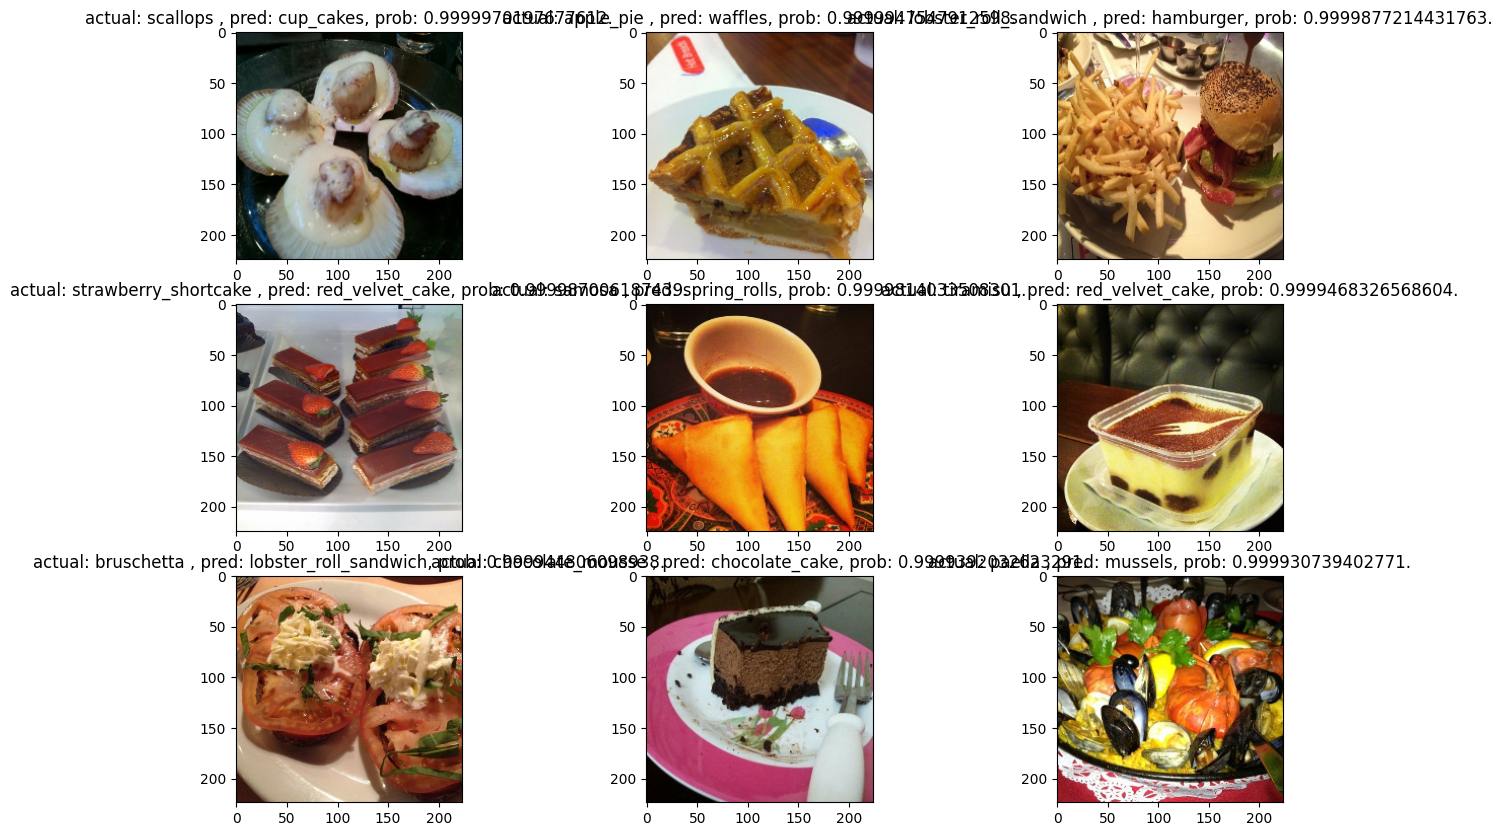

In [114]:
images_to_view=9
start_index=0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_and_prep_image(row[1], scale=False)
  _,_,_,_,pred_prob, y_true_classname,y_pred_classname, _ = row#Only interested in a few parameters in each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname} , pred: {y_pred_classname}, prob: {pred_prob}.")
  